In [1]:
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import numpy as np
import unidecode
import os
import re

from joblib import Parallel, delayed
from spellchecker import SpellChecker
spanish = SpellChecker(language='es')

### Reading data

In [2]:
need_df = pd.read_excel('./data/needs_v2.xlsx', engine='openpyxl')

### Post-processing - Words vs Setences

In [3]:
def process_one(row):
    need = row['name']
    
    a = None
    b = None
    if isinstance(need, str):
        n = re.sub(r'\W+', ' ', need)
        n = unidecode.unidecode(n)
        if n in ['juviluacion']:
            n = 'jubilacion'
        if len(n.split(' '))>1:
            a = n.lower()
        elif n != 'nr' and n!='igebdt':
            if re.search(r'\d[e|a|ra|era|deg]', n):
                b = 'NR'
                row['priority'] = re.sub(r'[A-z]+', '', n)                
            if len(n) != 1 and not re.search(r'\d+', n) or 'tpp' in n:
                b = n.lower().strip()
    return a, b, row

In [4]:
%%time
num_cores = multiprocessing.cpu_count()
response = Parallel(n_jobs=num_cores)(delayed(process_one)(row) \
                    for _, row in need_df.iterrows())

CPU times: user 1min 12s, sys: 779 ms, total: 1min 12s
Wall time: 1min 12s


In [5]:
def get_uniques(response, which='words'):
    k = 1 if which == 'words' else 0 
    strings = [r[k] for r in response if r[k] is not None]
    strings_row = [r[2] for r in response if r[k] is not None]
    uniques, counts = np.unique(strings, return_counts=True)
    indices = np.argsort(counts)
    sorted_u = uniques[indices]
    sorted_c = counts[indices]
    sorted_r = np.array(strings_row)[indices]
    return sorted_u, sorted_c, sorted_r

In [6]:
unique_words, counts_words, rows_words = get_uniques(response, which='words')
unique_sentences, counts_sentences, rows_sentences = get_uniques(response, which='sentences')

In [7]:
print('{} unique words\n{} unique sentences'.format(len(unique_words), len(unique_sentences)))

1259 unique words
21916 unique sentences


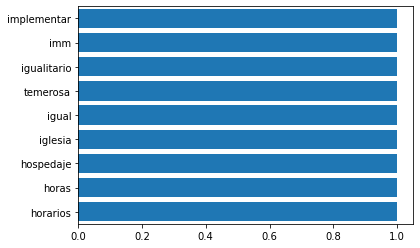

In [8]:
n = 10
plt.figure()
x = range(len(unique_words[:n]))
plt.barh(x, counts_words[:n])
plt.yticks(x, unique_words[:n])
plt.ylim(0.5, len(x)-0.5)
plt.show()

### Clustering 

In [9]:
import difflib

In [11]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = './files/embeddings-l-model.bin'
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xba in position 0: invalid start byte